D:\Other_All\Application_Documents\Medium\For_Work\Scisearch\开哥\南海垃圾\Code\ssea.py:14: RuntimeWarning: overflow encountered in exp
  get_weight = lambda dis_input:-damp_b*np.exp(damp_factor*dis_input)+damp_intercept


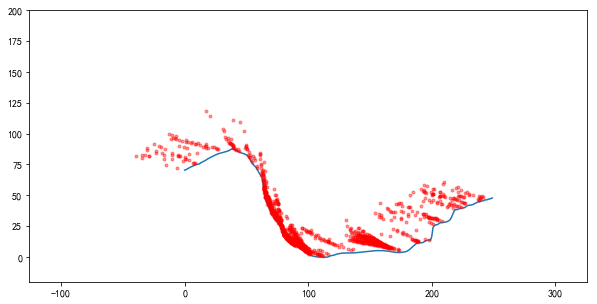

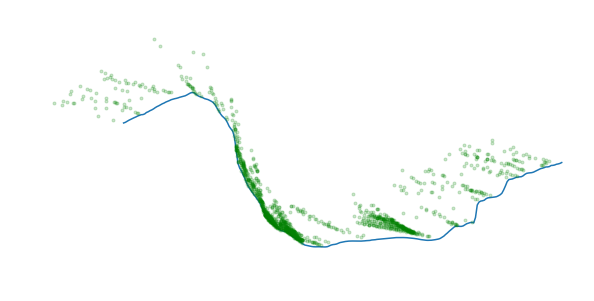

In [14]:
from ssea import *
from matplotlib import pyplot as plt 
from sklearn.cluster import AffinityPropagation
%matplotlib inline 

direction_ = '东北风'
crossx_ls,crossy_ls,trash_m = cross_esi(direction_)
train_set = np.c_[crossx_ls,crossy_ls]
#train_set,_ = filt_points(train_set)
#af = AffinityPropagation()
#af.fit(train_set)
#train_res = af.predict(train_set)

plt.figure(figsize = (10,5))
plt.rcParams['font.sans-serif'] = ['KaiTi']
plt.rcParams['axes.unicode_minus']=False
plt.plot(coast_x,coast)
#plt.plot(crossx_ls,crossy_ls,'r.')
plt.plot(train_set[:,0],train_set[:,1],'r.',alpha = 0.4)
plt.axis('equal')
plt.xlim(0,200)
plt.ylim(-20,200)
#plt.title('此图经过放缩后续数据无法用于分析',fontsize = 30)
plt.figure(figsize = (10,5))
plt.plot(coast_x,coast)
#plt.plot(crossx_ls,crossy_ls,'r.')
plt.plot(train_set[:,0],train_set[:,1],'g.',alpha = 0.2)
plt.axis('equal')
plt.box('off')
plt.axis('off')
plt.savefig('../论文/points_raw.png',transparent = True,dpi = 400)
#print(plt.set_facecolor)
#plt.xlim(0,200)
#plt.ylim(-20,200)
plt.show()

## 项目记录：
9月1日：
1. 完善了4个风向的情况，封装该交点返回功能
2. AP聚类算法复杂度过高，不宜用于此项目，电脑根本无法满足要求
3. 可以采用远离海岸的水流阻尼减少模型减少杂点
4. 可以采用概率分布的形式，找到可能的峰。
5. 离散化，四舍五入取整。（个数为AP聚类的权重）

9月2日:

解决方案：考虑多少范围内的交点。没必要做水速下降，权重也不好做。反射线其中之一为0即无法交出交点了。

建议还是采用kmeans比较快，直接取前几个中心。

水速下降和权重都做好了额...那就直接用权重配上K-means好了。

sample_weight参数（from sklearn.cluster import KMeans）

## KMeans算法

d:\other_all\application\python\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


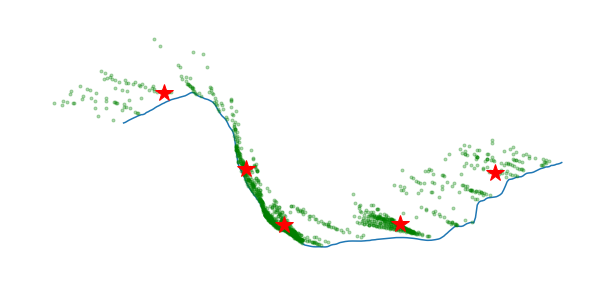

In [17]:
from sklearn.cluster import KMeans

n_ = 5
okm = KMeans(n_clusters = n_)
okm.fit(train_set,sample_weight = trash_m)
c_centers = okm.cluster_centers_

plt.figure(figsize = (10,5))
plt.rcParams['font.sans-serif'] = ['KaiTi']
plt.rcParams['axes.unicode_minus']=False
plt.plot(coast_x,coast)
#for i in range(n_):
    #plt.plot(train_set[okm.labels_==i,0],train_set[okm.labels_==i,1],'.',alpha = 0.3)
plt.plot(train_set[:,0],train_set[:,1],'g.',alpha=0.3)
plt.axis('equal')
plt.axis('off')
plt.box('off')
plt.plot(c_centers[:,0],c_centers[:,1],'r*',markersize = 18)
plt.savefig('../论文/res_'+direction_+'.png',transparent=True,dpi = 400)
plt.show()

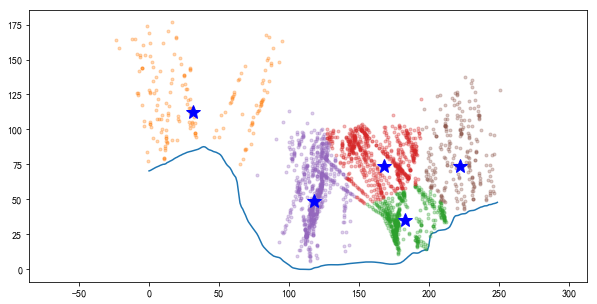

In [34]:
c_centers = okm.cluster_centers_

plt.figure(figsize = (10,5))
plt.rcParams['font.sans-serif'] = ['KaiTi']
plt.rcParams['axes.unicode_minus']=False
plt.plot(coast_x,coast)
for i in range(5):
    plt.plot(train_set[okm.labels_==i,0],train_set[okm.labels_==i,1],'.',alpha = 0.3)
plt.axis('equal')
plt.axis('off')
plt.box('off')
plt.plot(c_centers[:,0],c_centers[:,1],'r*',markersize = 15)
plt.show()

### KMeans算法----轮廓系数（结论：感觉没什么用）

In [35]:
a = np.ones((3,2))
b = a-0.5*np.ones((1,2))
c =(b**2).sum(axis = 1)
c

array([0.5, 0.5, 0.5])

In [36]:
def mean_unsim(data_other_same,i_data):
    return np.sqrt(((data_other_same-i_data)**2).sum(axis = 1 )).mean()
    
def calc_performance(data,result):
    '''计算轮廓系数'''
    result = result.ravel()
    result_set = set(result.tolist())
    result_set = list(result_set)
    index_ls = list(range(data.shape[0]))
    side_ls = []
    for i in index_ls :#遍历每一个点，进行每个点的计算
        i_data = data[i,:]
        index_other = index_ls.copy().remove(i)
        data_other = data[index_other,:]
        result_other = result[index_other]
        data_other_same = data_other[result_other == result[i]] 
        a_i = np.sqrt(((data_other_same-i_data)**2).sum(axis = 1 )).mean()
        b_i_ls = []
        for j in result_set:
            if j == result[i]:
                continue 
            data_other_diff = data_other[result_other == j]
            b_i_t = mean_unsim(data_other_diff,i_data)
            b_i_ls.append(b_i_t)
        b_i = min(b_i_ls)
        side_factor_one = (b_i-a_i)/(max(a_i,b_i))
        side_ls.append(side_factor_one)
    return np.mean(side_ls)
            

data_result = okm.labels_
calc_performance(train_set,data_result)

0.4341360369986163

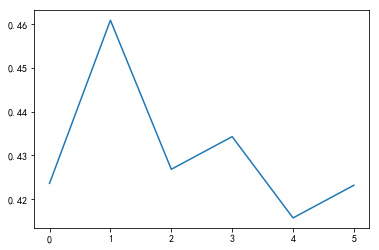

In [37]:
cp_ls = []
for n in range(2,8):
    okm = KMeans(n_clusters = n)
    okm.fit(train_set,sample_weight = trash_m)
    data_result = okm.labels_
    cp_ls.append(calc_performance(train_set,data_result))
plt.plot(cp_ls)

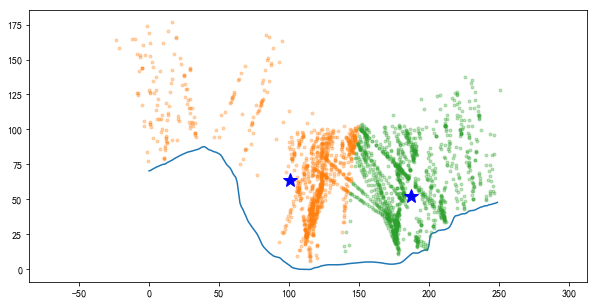

In [38]:
n = 2 
okm = KMeans(n_clusters = n)
okm.fit(train_set,sample_weight = trash_m)
c_centers = okm.cluster_centers_

plt.figure(figsize = (10,5))
plt.rcParams['font.sans-serif'] = ['KaiTi']
plt.rcParams['axes.unicode_minus']=False
plt.plot(coast_x,coast)
for i in range(n):
    plt.plot(train_set[okm.labels_==i,0],train_set[okm.labels_==i,1],'.',alpha = 0.3)
plt.axis('equal')
plt.plot(c_centers[:,0],c_centers[:,1],'b*',markersize = 15)
plt.show()

### 从结果来看，水速随着远离海岸下降还是必要的...思路回归的原因是无法通过AP聚类完成此类任务，也无法通过3-$\sigma$等方式起到滤去远离海岸的点，甚至于，远离海岸是这个模型的主要结果。

### 采用离散化方式

In [6]:
train_set_bk = train_set.copy()
print('离散化前的交点数量为',train_set.shape[0])

离散化前的交点数量为 17


In [7]:
train_set = train_set_bk.copy()
train_set = np.round(train_set)

train_set = train_set.tolist()
train_set_tuple = [tuple(i) for i in train_set]
train_set = set(train_set_tuple)

In [8]:
print('离散化后的交点数量为',len(train_set))

离散化后的交点数量为 16


### 数量减半，但我觉得还是好多

In [9]:
train_set = list(train_set)
num_ls = [ ]
for i in train_set: 
    num_ls.append(train_set_tuple.count(i))


In [10]:
num_ls = np.array(num_ls)
print('不是孤立点的交点数量为',num_ls[num_ls>1].size)

不是孤立点的交点数量为 1


### 最好的应该还是给个随距离的减少，因为有些点离水流的出发点还是太远了
### （下图单纯得找出了四舍五入后不是单个点的地方）

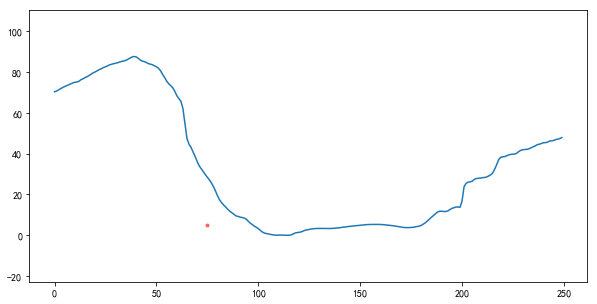

In [11]:
coor = np.array(train_set)[num_ls[num_ls>1],:]

plt.figure(figsize = (10,5))
plt.plot(coast_x,coast)
#plt.plot(crossx_ls,crossy_ls,'r.')
plt.plot(coor[:,0],coor[:,1],'r.',alpha = 0.5)
plt.axis('equal')
#plt.xlim(0,200)
#plt.ylim(-20,200)
plt.show()

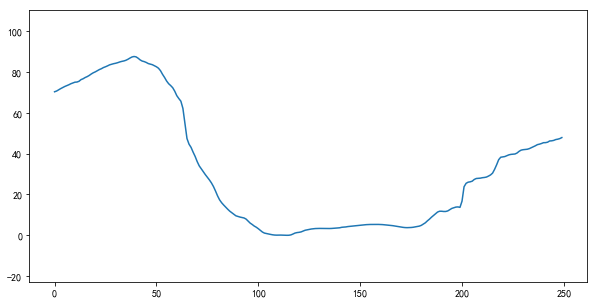

In [12]:
coor = np.array(train_set)[num_ls[num_ls>1],:]

coor,_ = filt_points(coor,distance = 'euc',factor = 1)
plt.figure(figsize = (10,5))
plt.plot(coast_x,coast)
#plt.plot(crossx_ls,crossy_ls,'r.')
plt.plot(coor[:,0],coor[:,1],'r.',alpha = 0.5)
plt.axis('equal')
#plt.xlim(0,200)
#plt.ylim(-20,200)
plt.show()

In [21]:
coor

array([[  89.,   11.],
       [  89.,   11.],
       [  89.,   11.],
       ...,
       [  69.,   38.],
       [-415.,  153.],
       [  89.,   11.]])

### AP聚类，结果不可靠，随缘，先放着，缺乏了极其重要的密度信息
### 现在好了，现在经过权重和水速 下降后，数量少到可以进行AP聚类了

In [38]:
from sklearn.cluster import AffinityPropagation

af = AffinityPropagation()
af.fit(train_set)
train_res = af.predict(train_set)

In [42]:
len(set(train_res))

1948

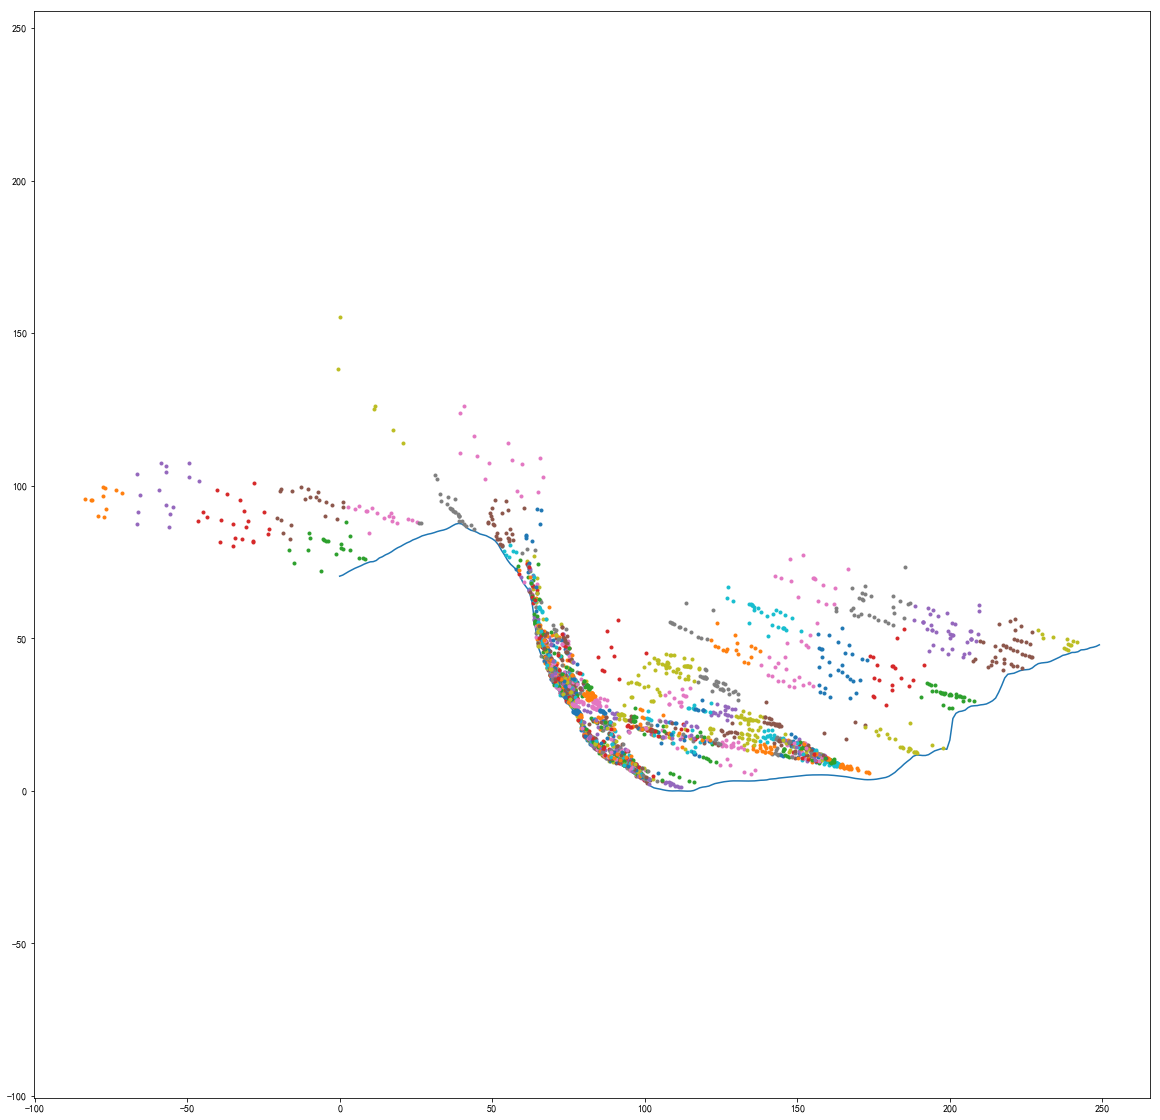

In [58]:
plt.figure(figsize = (20,20))
plt.rcParams['font.sans-serif'] = ['KaiTi']
plt.rcParams['axes.unicode_minus']=False
plt.plot(coast_x,coast)
#plt.plot(train_set[:,0],train_set[:,1],'r.',alpha = 0.5)
plt.axis('equal')
for i in np.arange(0,np.unique(train_res).size):
    plt.plot(train_set[train_res==i,0],train_set[train_res==i,1],'.')
plt.show()

## 水速下降模型
$$A\sqrt{e^{-\beta d}}$$
#### 这几乎就是线性下降啊...

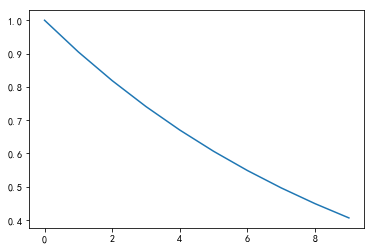

In [10]:
xxx = np.arange(10)
yyy = np.sqrt(np.exp(-0.2*xxx))
plt.plot(xxx,yyy)
plt.show()

### 自定义水流下降模型
$$ $$

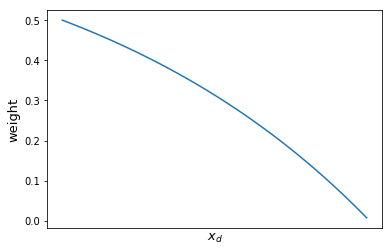

In [12]:
from matplotlib import pyplot as plt 
%matplotlib inline 
import numpy as np 

d = 100 
a = 0.01 
b = 0.5/(-1+np.exp(a*d))
c = 0.5+b
xxx = np.arange(100)
yyy = -b*np.exp(a*xxx)+c
plt.plot(xxx,yyy)
plt.xticks([])
#plt.yticks()
plt.ylabel('weight',fontsize = 13 )
plt.xlabel('$x_d$',fontsize = 13 )
plt.savefig('../论文/xd_weight.png')
plt.show()

In [13]:
a,b,c,d

(0.01, 0.2909883534346632, 0.7909883534346632, 100)